In [2]:
import duckdb

# Create the database we'll save our work to and load the extensions we'll need
con = duckdb.connect("conflation.ddb")
con.sql("install spatial")
con.sql("install httpfs")
con.sql("load spatial")
con.sql("load httpfs")

# Load the CSV downloaded from Snowflake
con.sql("CREATE TABLE IF NOT EXISTS scores AS SELECT * FROM read_csv('scores.csv', ignore_errors=True)")

Download the Overture Places data. There's  a lot going on here, but what we're doing is...
1. Create a bounding box around all the Alameda County records
2. Get all the places from Overture in that bounding box, with a confidence score > 0.5
3. Finally transform these results into a format that matches the Alameda County Data

In [93]:

con.sql("""
    DROP TABLE IF EXISTS places;
    CREATE TABLE IF NOT EXISTS places AS 

    SELECT 
        id, 
        upper(names['primary']) as Facility_Name, 
        upper(addresses[1]['freeform']) as Address, 
        upper(addresses[1]['locality']) as City, 
        upper(addresses[1]['region']) as State, 
        left(addresses[1]['postcode'], 5) as Zip, 
        geometry, 
        ST_X(geometry) as Longitude,
        ST_Y(geometry) as Latitude,
        categories,
        *
    FROM (
        SELECT * 
        FROM read_parquet('s3://overturemaps-us-west-2/release/2024-12-18.0/theme=places/type=place/*', filename=true, hive_partitioning=1)
        WHERE addresses[1] IS NOT NULL AND
            bbox.xmin BETWEEN -74.2591 AND -73.7004 AND
            bbox.ymin BETWEEN 40.4774 AND 40.9176 AND
            confidence > 0.5 AND
            categories.primary IN ('eat_and_drink', 'restaurant')
    );
""")

In [94]:
con.sql("SELECT * FROM places LIMIT 5").show()
con.sql("SELECT * FROM scores LIMIT 5").show()

┌──────────────────────────────────┬──────────────────────────┬─────────────────────┬───────────────┬─────────┬─────────┬────────────────────────────────┬─────────────┬────────────┬────────────────────────────────────────────────────────────────────────────────────────┬──────────────────────────────────┬────────────────────────────────┬──────────────────────────────────────────────────────────────────────────────┬─────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬────────────────────────────────────────────────────────────────────────────────────────┬────────────────────┬────────────────────────────────────┬────────────────────────────────────────────┬───────────┬────────────────┬───────────────────────────────────────────────────────────────

In [95]:
con.sql("""
        SELECT 'scores' as table_name, COUNT(*) as row_count FROM scores
    UNION ALL
    SELECT 'places' as table_name, COUNT(*) as row_count FROM places
        """).show()
        

┌────────────┬───────────┐
│ table_name │ row_count │
│  varchar   │   int64   │
├────────────┼───────────┤
│ scores     │     21681 │
│ places     │      4119 │
└────────────┴───────────┘



In [96]:
# con.sql("INSTALL h3 FROM community")
# con.sql("LOAD h3")

# # Add H3 indexs to each table
# con.sql("ALTER TABLE places ADD COLUMN IF NOT EXISTS h3 uint64")
# con.sql("ALTER TABLE scores ADD COLUMN IF NOT EXISTS h3 uint64")
# con.sql("UPDATE places SET h3 = h3_latlng_to_cell(Latitude, Longitude, 7)")
# con.sql("UPDATE scores SET h3 = h3_latlng_to_cell(GEOGRAPHY_LAT, GEOGRAPHY_LON, 7)")

In [97]:

exact_name_match_df = con.sql("""
SELECT
    s.Address, p.Address
FROM (
    SELECT Address
    FROM scores
) s
JOIN places p
    ON s.Address = p.Address
""").df()

In [98]:
exact_name_match_df.head()
exact_name_match_df.count()

Address      30
Address_1    30
dtype: int64

In [99]:
total_venues = con.sql("SELECT count(*) FROM scores").fetchone()[0]
exact_name_match_rate = exact_name_match_df.shape[0] / total_venues
print(f"Exact name match rate: {exact_name_match_rate:.2%}")


Exact name match rate: 0.14%


In [100]:
# con.sql("""
# ALTER TABLE places ADD COLUMN IF NOT EXISTS full_address VARCHAR;

# UPDATE places 
# SET full_address = TRIM(CONCAT_WS(', ', 
#     NULLIF(Address, ''),
#     NULLIF(City, ''),
#     NULLIF(State, ''),
#     NULLIF(Zip, '')
# ));
# """)

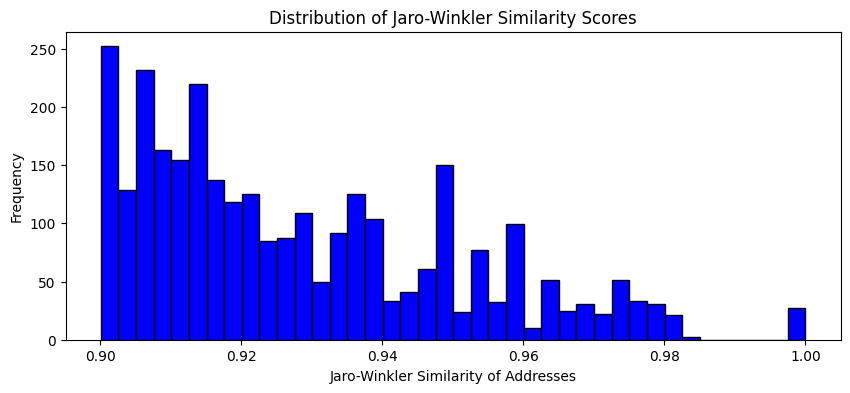

,score_address,place_address,Facility_Name,Longitude,Latitude,Block,Lot,Building_Class,Tax_Class,Building_Count,DOF_Gross_Square_Footage,Address,BoroughName,BBL,ENERGY STAR Score,LetterScore,h3,similarity,rank
0,2175 BROADWAY,2175 BROADWAY,ALLURE RESTAURANT AND LOUNGE,-73.981169,40.782423,1168,56,H3,4,1,121147,2175 BROADWAY,MANHATTAN,1011680056,34,D,NaN,1.0,1
1,274 BROADWAY,274 BROADWAY,EMPERADOR ELIAS RESTAURANT,-73.958785,40.708596,153,1,O6,0,1,239671,274 BROADWAY,MANHATTAN,1001530001,81,B,NaN,1.0,1
2,2 AVENUE OF THE AMERICAS,2 AVENUE OF THE AMERICAS,ROXY BAR,-74.004959,40.719193,191,1,HB,4,1,133895,2 AVENUE OF THE AMERICAS,MANHATTAN,1001910001,38,D,NaN,1.0,1
3,3660 BROADWAY,3660 BROADWAY,NEW DELI 1,-73.947430,40.830295,2083,1,D7,2,1,71112,3660 BROADWAY,MANHATTAN,1020830001,2,D,NaN,1.0,1
4,1900 BROADWAY,1900 BROADWAY,EPICERIE BOULUD,-73.981644,40.771677,1116,7501,R0,2,1,1182195,1900 BROADWAY,MANHATTAN,1011167501,13,D,NaN,1.0,1
5,3570 BROADWAY,3570 BROADWAY,HAMILTON'S BAKERY,-73.949614,40.827190,2078,61,D7,2,1,46987,3570 BROADWAY,MANHATTAN,1020780061,41,D,NaN,1.0,1
6,4141 BROADWAY,4141 BROADWAY,MALECON RESTAURANT,-73.938533,40.846379,2142,224,D7,2,1,71896,4141 BROADWAY,MANHATTAN,1021420224,1,D,NaN,1.0,1
7,47 BROADWAY,47 BROADWAY,CHINA CHALET,-74.012944,40.706500,20,12,K4,4,1,27640,47 BROADWAY,MANHATTAN,1000200012,0,F,NaN,1.0,1
8,1500 BROADWAY,1500 BROADWAY,GORDON RAMSAY FISH & CHIPS,-73.985677,40.756797,996,1,O4,4,1,493107,1500 BROADWAY,MANHATTAN,1009960001,28,D,NaN,1.0,1
9,3920 BROADWAY,3920 BROADWAY,GRAN MAYA RESTAURANT,-73.941298,40.838558,2122,69,D7,2,1,45312,3920 BROADWAY,MANHATTAN,1021220069,14,D,NaN,1.0,1


In [131]:
import matplotlib.pyplot as plt

df = con.sql("""             
    WITH RankedMatches AS (
        SELECT 
            s.Address as score_address,
            p.Address as place_address,
             p.Facility_Name,
             Longitude,
             Latitude,
             s.*,
            jaro_winkler_similarity(s.Address, p.Address) as similarity,
            ROW_NUMBER() OVER (PARTITION BY s.Address ORDER BY jaro_winkler_similarity(s.Address, p.Address) DESC) as rank
        FROM scores s
        CROSS JOIN places p
        WHERE jaro_winkler_similarity(s.Address, p.Address) > 0.9  -- Threshold to avoid irrelevant matches
    )
    SELECT 
        *
    FROM RankedMatches
    WHERE rank = 1
    ORDER BY similarity DESC
    """).df()

# Visualize the distribution of Jaro-Winkler Similarity (jws) scores
plt.figure(figsize=(10, 4))
plt.hist(df['similarity'], bins=40, color='blue', edgecolor='black')
plt.title('Distribution of Jaro-Winkler Similarity Scores')
plt.xlabel('Jaro-Winkler Similarity of Addresses')
plt.ylabel('Frequency')
plt.show()

df.head(10)

In [135]:
filtered_df = df[(df['similarity'] >= 0.9)]
print(f"Number of matches with similarity scores between 0.8 and 0.85: {len(filtered_df)}")
display(filtered_df.head(10))

df.to_csv('green-menu/public/data/restaurants.csv', index=False)


Number of matches with similarity scores between 0.8 and 0.85: 3003


,score_address,place_address,Facility_Name,Longitude,Latitude,Block,Lot,Building_Class,Tax_Class,Building_Count,DOF_Gross_Square_Footage,Address,BoroughName,BBL,ENERGY STAR Score,LetterScore,h3,similarity,rank
0,2175 BROADWAY,2175 BROADWAY,ALLURE RESTAURANT AND LOUNGE,-73.981169,40.782423,1168,56,H3,4,1,121147,2175 BROADWAY,MANHATTAN,1011680056,34,D,NaN,1.0,1
1,274 BROADWAY,274 BROADWAY,EMPERADOR ELIAS RESTAURANT,-73.958785,40.708596,153,1,O6,0,1,239671,274 BROADWAY,MANHATTAN,1001530001,81,B,NaN,1.0,1
2,2 AVENUE OF THE AMERICAS,2 AVENUE OF THE AMERICAS,ROXY BAR,-74.004959,40.719193,191,1,HB,4,1,133895,2 AVENUE OF THE AMERICAS,MANHATTAN,1001910001,38,D,NaN,1.0,1
3,3660 BROADWAY,3660 BROADWAY,NEW DELI 1,-73.947430,40.830295,2083,1,D7,2,1,71112,3660 BROADWAY,MANHATTAN,1020830001,2,D,NaN,1.0,1
4,1900 BROADWAY,1900 BROADWAY,EPICERIE BOULUD,-73.981644,40.771677,1116,7501,R0,2,1,1182195,1900 BROADWAY,MANHATTAN,1011167501,13,D,NaN,1.0,1
5,3570 BROADWAY,3570 BROADWAY,HAMILTON'S BAKERY,-73.949614,40.827190,2078,61,D7,2,1,46987,3570 BROADWAY,MANHATTAN,1020780061,41,D,NaN,1.0,1
6,4141 BROADWAY,4141 BROADWAY,MALECON RESTAURANT,-73.938533,40.846379,2142,224,D7,2,1,71896,4141 BROADWAY,MANHATTAN,1021420224,1,D,NaN,1.0,1
7,47 BROADWAY,47 BROADWAY,CHINA CHALET,-74.012944,40.706500,20,12,K4,4,1,27640,47 BROADWAY,MANHATTAN,1000200012,0,F,NaN,1.0,1
8,1500 BROADWAY,1500 BROADWAY,GORDON RAMSAY FISH & CHIPS,-73.985677,40.756797,996,1,O4,4,1,493107,1500 BROADWAY,MANHATTAN,1009960001,28,D,NaN,1.0,1
9,3920 BROADWAY,3920 BROADWAY,GRAN MAYA RESTAURANT,-73.941298,40.838558,2122,69,D7,2,1,45312,3920 BROADWAY,MANHATTAN,1021220069,14,D,NaN,1.0,1


In [136]:
# exact_name_match_df = con.sql("""
                              
# SELECT
#     v.VENUE_ID as vid, p.id as gers, v.VENUE_NAME as v_name, p.Facility_Name as p_name, v.NAME, 
#         p.full_address
# FROM (
#     SELECT DISTINCT VENUE_NAME, VENUE_ID, NAME, h3
#     FROM venues WHERE MSA_ID = 1
# ) v
# JOIN places p
#     ON v.h3 = p.h3
#     AND v.VENUE_NAME = p.Facility_Name
#     AND jaro_winkler_similarity(upper(v.NAME), upper(p.full_address)) > 0.8
# """).df()
# display(exact_name_match_df)

# exact_name_match_rate = exact_name_match_df.shape[0] / total_venues
# display(f"Exact name match rate: {exact_name_match_rate:.2%}")


In [137]:
import ollama

def get_embedding(text):
    return ollama.embeddings(
        model='mxbai-embed-large', 
        prompt=text
    )['embedding']

venues_df = con.sql("""
SELECT VENUE_ID as vid, concat(VENUE_NAME, ',', NAME) as description FROM venues WHERE MSA_ID = 1 GROUP BY 2, 1
""").df()
places_df = con.sql("""
SELECT id as gers, concat(Facility_Name, ',', full_address, ',', City, ',', Zip) as description FROM places GROUP BY description, gers
""").df()


# # Compute the embeddings
venues_df['embedding'] = venues_df['description'].apply(lambda x: get_embedding(x))
# places_df['embedding'] = places_df['description'].apply(lambda x: get_embedding(x))

ModuleNotFoundError: No module named 'ollama'

In [66]:

places_df = con.sql("""
SELECT id as gers, concat(Facility_Name, ',', full_address, ',', City, ',', State, ',', Zip) as description FROM places WHERE State = 'NY' GROUP BY description, gers
""").df()


# # Compute the embeddings
places_df['embedding'] = places_df['description'].apply(lambda x: get_embedding(x))

In [74]:
venues_df['h3'] = venues_df['vid'].apply(lambda x: con.sql("SELECT h3 from venues WHERE VENUE_ID = " + str(x)))


In [77]:
# Fix for getting h3 values
places_df['h3'] = places_df['gers'].apply(lambda x: con.sql(f"SELECT h3 from places WHERE id = '{x}'").fetchone()[0])

In [87]:
venues_df['h3'] = venues_df['vid'].apply(lambda x: con.sql(f"SELECT h3 from venues WHERE VENUE_ID = {x}").fetchone()[0])


In [89]:
from sentence_transformers.util import cos_sim
import numpy as np
import pandas as pd

def generate_search_embedding(text):
    return ollama.embeddings(
        model='mxbai-embed-large', 
        prompt=text
    )['embedding']

results_df = pd.DataFrame(columns=['v_description', 'p_description', 'vid', 'gers', 'h3', 'similarity_score'])
for index, row in venues_df.iterrows():
    # Generate the candidate embeddings
    print(row['h3'])


    print("venues_df h3 type:", venues_df['h3'].dtype)
    print("places_df h3 type:", places_df['h3'].dtype)

    # Convert to same type (example - adjust based on what we find)
    venues_df['h3'] = venues_df['h3'].astype('uint64')
    places_df['h3'] = places_df['h3'].astype('uint64')


    candidate_places = places_df[places_df['h3'] == row['h3']]

    # Debug: print number of candidates found
    print(f"Found {len(candidate_places)} candidates for h3 {row['h3']}")
    
    # Skip if no candidates found
    if len(candidate_places) == 0:
        print(f"Skipping venue {row['vid']} - no candidates found")
        continue

    sims = cos_sim(row['embedding'], candidate_places['embedding'].tolist())
    
    # Find the highest ranking score and the associated row
    max_sim_index = sims.argmax().item()
    max_sim_score = sims[0][max_sim_index].item()
    highest_ranking_row = candidate_places.iloc[max_sim_index]

    # Print the results
    # Add results to the new DataFrame
    new_row = pd.DataFrame({
        'v_description': row['description'],
        'p_description': highest_ranking_row['description'],
        'vid': row['vid'],
        'gers': highest_ranking_row['gers'],
        'h3': row['h3'],
        'similarity_score': max_sim_score
    }, index=[index])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

results_df

608725949323673599
venues_df h3 type: uint64
places_df h3 type: uint64
Found 0 candidates for h3 608725949323673599
Skipping venue 122190 - no candidates found
608726166169190399
venues_df h3 type: uint64
places_df h3 type: uint64
Found 0 candidates for h3 608726166169190399
Skipping venue 121557 - no candidates found
608725922312355839
venues_df h3 type: uint64
places_df h3 type: uint64
Found 362 candidates for h3 608725922312355839
608725951773147135
venues_df h3 type: uint64
places_df h3 type: uint64
Found 6530 candidates for h3 608725951773147135


/var/folders/cm/6dp7fzsx6nb7c3l30dks_c_m0000gp/T/ipykernel_6249/3145778950.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


608725951840255999
venues_df h3 type: uint64
places_df h3 type: uint64
Found 10988 candidates for h3 608725951840255999
608725943250321407
venues_df h3 type: uint64
places_df h3 type: uint64
Found 197 candidates for h3 608725943250321407
608725952729448447
venues_df h3 type: uint64
places_df h3 type: uint64
Found 462 candidates for h3 608725952729448447
608725924342398975
venues_df h3 type: uint64
places_df h3 type: uint64
Found 1657 candidates for h3 608725924342398975
608725951873810431
venues_df h3 type: uint64
places_df h3 type: uint64
Found 17 candidates for h3 608725951873810431
608725924560502783
venues_df h3 type: uint64
places_df h3 type: uint64
Found 21040 candidates for h3 608725924560502783
608725951773147135
venues_df h3 type: uint64
places_df h3 type: uint64
Found 6530 candidates for h3 608725951773147135
608725943954964479
venues_df h3 type: uint64
places_df h3 type: uint64
Found 0 candidates for h3 608725943954964479
Skipping venue 191288 - no candidates found
608725924

,v_description,p_description,vid,gers,h3,similarity_score
0,"Spruce It Up Salon NY,334 Hempstead Ave, West ...","SPRUCE IT UP SALON NY,334 HEMPSTEAD AVE, HEMPS...",170264,08f2a1004c50e16203f97412a6a2b43c,608725922312355839,0.970360
1,"agsdg,123 William St, New York, NY 10038, USA","AGP FINANCIAL DISTRICT,17 STATE ST, NEW YORK, ...",84655,08f2a1072815a498030ab4ea86fe558e,608725951773147135,0.789204
2,"Matchaful,184 Prince St, New York, NY 10012, USA","MATCHAFUL,217 MULBERRY ST, NEW YORK, NY, 10012...",228022,08f2a1072c14d92d0384f9dd31553ce2,608725951840255999,0.923261
3,"Club Pilates,5 N Airmont Rd, Airmont, NY 10901...","CLUB PILATES,5 N AIRMONT RD, SUFFERN, NY, 1090...",189956,08f2a1052c854cd0031028720d9a6b4b,608725943250321407,0.908215
4,"Longchamp Training 1:1,6161 Strickland Ave, Br...","JAMAICA BAY RIDING ACADEMY,7000 SHORE PKWY, BR...",206716,08f2a1076cd868f403533dec787d33c3,608725952729448447,0.718869
...,...,...,...,...,...,...
5161,"Simply Therapeutic,49-04 43rd Ave, Flushing, N...","DIRECT CLEAN SOLUTIONS,36-06 43RD AVE, NEW YOR...",87979,08f2a100d51a81620306b4f359967350,608725924610834431,0.698196
5162,"O'Salon,212 Rogers Ave, Brooklyn, NY 11225, USA","O SALON,212 ROGERS AVE, NEW YORK, NY, 11225,NE...",138268,08f2a100db02a87303865d48479b574c,608725924711497727,0.928018
5163,"Le Botaniste,156 Columbus Ave, New York, NY 10...","LE BOTANISTE,156 COLUMBUS AVE, NEW YORK, NY, 1...",220140,08f2a1008bad568203b371ae10b13b5c,608725923369320447,0.985815
5164,"Full Circle ,2610 Frederick Douglass Blvd, New...","REVERENCE,2592 FREDERICK DOUGLASS BLVD, NEW YO...",238305,08f2a100ab4899b203925079f13d260b,608725923906191359,0.780595


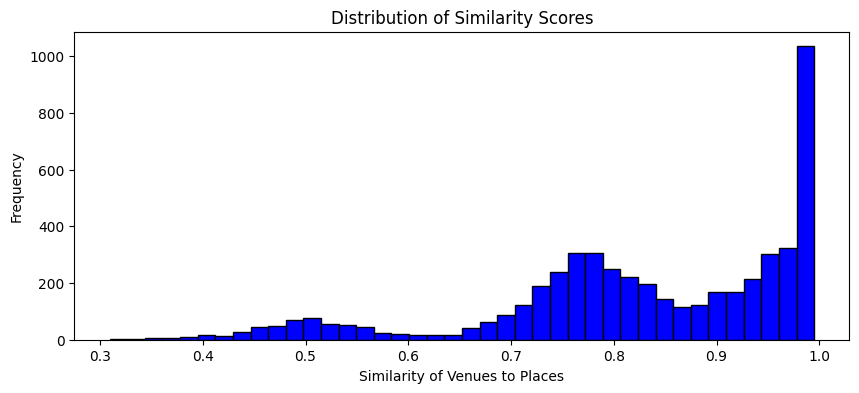

In [91]:
# Visualize the distribution of Jaro-Winkler Similarity (jws) scores
plt.figure(figsize=(10, 4))
plt.hist(results_df['similarity_score'], bins=40, color='blue', edgecolor='black')
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity of Venues to Places')
plt.ylabel('Frequency')
plt.show()

    Threshold  Venues Percentage
0        1.00       0       0.0%
1        0.99     211       4.1%
2        0.98     952      18.4%
3        0.97    1195      23.1%
4        0.96    1373      26.6%
5        0.95    1536      29.7%
6        0.94    1713      33.2%
7        0.93    1843      35.7%
8        0.92    1940      37.6%
9        0.91    2027      39.2%
10       0.90    2135      41.3%
11       0.89    2221      43.0%
12       0.88    2304      44.6%
13       0.87    2370      45.9%
14       0.86    2428      47.0%
15       0.85    2504      48.5%
16       0.84    2593      50.2%
17       0.83    2701      52.3%
18       0.82    2823      54.6%
19       0.81    2946      57.0%
20       0.80    3091      59.8%


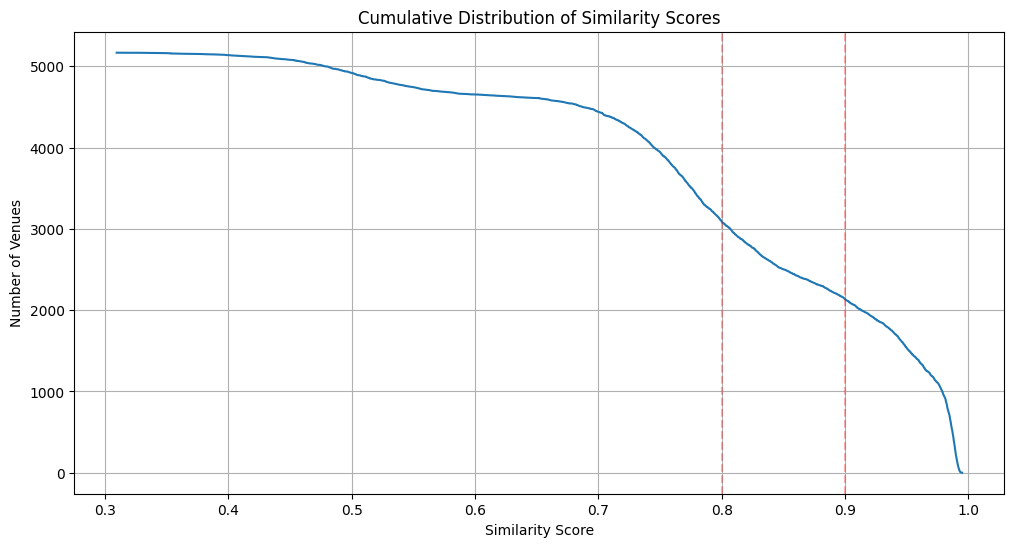

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# Sort similarity scores in descending order
sorted_scores = np.sort(results_df['similarity_score'])[::-1]
cumulative_venues = np.arange(1, len(sorted_scores) + 1)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(sorted_scores, cumulative_venues)
plt.grid(True)
plt.title('Cumulative Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Number of Venues')

# Add some threshold lines for reference
plt.axvline(x=0.9, color='r', linestyle='--', alpha=0.3)
plt.axvline(x=0.8, color='r', linestyle='--', alpha=0.3)

# Create a table with specific thresholds
thresholds = [1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.90, 0.89, 0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.80]
stats = []
for threshold in thresholds:
    count = (results_df['similarity_score'] >= threshold).sum()
    percentage = (count / len(results_df)) * 100
    stats.append({
        'Threshold': threshold,
        'Venues': count,
        'Percentage': f"{percentage:.1f}%"
    })

print(pd.DataFrame(stats))

plt.show()

In [97]:
results_df.to_csv('venue_place_matches.csv', index=False)

In [98]:
results_df['primary_category'] = results_df['gers'].apply(
    lambda x: con.sql(f"SELECT categories['primary'] FROM places WHERE id = '{x}'").fetchone()[0]
)
results_df['alternate_categories'] = results_df['gers'].apply(
    lambda x: con.sql(f"SELECT categories['alternate'] FROM places WHERE id = '{x}'").fetchone()[0]
)

# Save updated results
results_df.to_csv('venue_place_matches.csv', index=False)